In [14]:
# ---------------- Install Requirements ----------------
import subprocess
import sys

print("📦 Installing requirements...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirement.txt"])
print("✅ Requirements installed!\n")

📦 Installing requirements...
✅ Requirements installed!



In [15]:
# ---------------- FastAPI Init ----------------

import uvicorn
import threading
import time

# ----------------- Server handle -----------------
server = None  # global

def start_server():
    global server
    config = uvicorn.Config("main:app", host="127.0.0.1", port=8000, reload=False)
    server = uvicorn.Server(config)
    server.run()  # blocking call

# ----------------- Start server thread -----------------
thread = threading.Thread(target=start_server, daemon=True)
thread.start()
time.sleep(1)
print("✅ FastAPI server should be running now!")
print("🌐 Open your browser: http://127.0.0.1:8000/docs")

# ----------------- Stop function -----------------
def stop_server():
    global server
    if server:
        print("🛑 Stopping FastAPI server...")
        server.should_exit = True  # uvicorn خودش می‌بینه و می‌بنده
        thread.join()
        print("✅ FastAPI server stopped.")
    else:
        print("⚠️ Server not running.")


INFO:     Started server process [26383]
INFO:     Waiting for application startup.
ERROR:    Traceback (most recent call last):
  File "/home/hirad/Desktop/dadekavi-project/telegram-rpc-api/venv/lib/python3.13/site-packages/starlette/routing.py", line 694, in lifespan
    async with self.lifespan_context(app) as maybe_state:
               ~~~~~~~~~~~~~~~~~~~~~^^^^^
  File "/usr/lib/python3.13/contextlib.py", line 214, in __aenter__
    return await anext(self.gen)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/hirad/Desktop/dadekavi-project/telegram-rpc-api/main.py", line 67, in lifespan
    await client.start()
  File "/home/hirad/Desktop/dadekavi-project/telegram-rpc-api/venv/lib/python3.13/site-packages/telethon/client/auth.py", line 141, in _start
    me = await self.get_me()
         ^^^^^^^^^^^^^^^^^^^
  File "/home/hirad/Desktop/dadekavi-project/telegram-rpc-api/venv/lib/python3.13/site-packages/telethon/client/users.py", line 170, in get_me
    me = (await self(
          ^^^

✅ FastAPI server should be running now!
🌐 Open your browser: http://127.0.0.1:8000/docs


In [5]:
import pandas as pd
import sqlite3
import requests
import re
from datetime import datetime, timedelta, timezone

DB_PATH = "data/data.db"
API_URL = "http://localhost:8000/read"
PER_PAGE = 100
CACHE_HOURS = 24
UTC = timezone.utc

# ------------------- Crawl & Cache -------------------
def load_full_channel_history(username: str) -> pd.DataFrame:
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    now = datetime.now(UTC)
    cache_limit = now - timedelta(hours=CACHE_HOURS)
    all_posts = []
    page = 1
    stats = {"from_api": 0, "from_cache": 0, "pages_loaded": 0}

    while True:
        params = {"username": username, "page": page, "per_page": PER_PAGE}
        try:
            resp = requests.get(API_URL, params=params, timeout=10)
        except requests.RequestException as e:
            print(f"❌ Request failed on page {page}: {e}")
            break
        if resp.status_code >= 500:
            print(f"🛑 Server error on page {page}, stopping crawl.")
            break
        if resp.status_code != 200:
            print(f"⚠️ Status {resp.status_code} on page {page}, stopping.")
            break

        posts = resp.json()
        if not posts:
            print(f"📭 No more posts on page {page}.")
            break

        stats["pages_loaded"] += 1

        for msg in posts:
            message_id = msg["message_id"]
            cursor.execute(
                "SELECT text, date, fetched_at FROM posts WHERE channel_username=? AND message_id=?",
                (username, message_id),
            )
            row = cursor.fetchone()
            if row:
                fetched_at = datetime.fromisoformat(row[2])
                if fetched_at.tzinfo is None:
                    fetched_at = fetched_at.replace(tzinfo=UTC)
                if fetched_at > cache_limit:
                    all_posts.append((username, message_id, row[0], row[1], fetched_at))
                    stats["from_cache"] += 1
                    continue

            cursor.execute(
                """
                INSERT OR REPLACE INTO posts
                (channel_username, message_id, text, date, fetched_at)
                VALUES (?, ?, ?, ?, ?)
                """,
                (username, message_id, msg["message"], msg["date"], now.isoformat()),
            )
            all_posts.append((username, message_id, msg["message"], msg["date"], now))
            stats["from_api"] += 1

        conn.commit()
        page += 1

    conn.close()

    df = pd.DataFrame(all_posts, columns=["channel_username", "message_id", "text", "date", "fetched_at"])
    df["date"] = pd.to_datetime(df["date"], utc=True)
    df = df.sort_values("date", ascending=False)
    print("\n📊 Crawl Report")
    print("────────────────────────")
    print(f"📄 Pages loaded     : {stats['pages_loaded']}")
    print(f"🌐 Posts from API   : {stats['from_api']}")
    print(f"💾 Posts from cache : {stats['from_cache']}")
    print(f"📦 Total posts      : {len(df)}")
    return df


In [16]:
df = load_full_channel_history("ostad_elmosi")

INFO:     127.0.0.1:33084 - "GET /read?username=ostad_elmosi&page=1&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33094 - "GET /read?username=ostad_elmosi&page=2&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33106 - "GET /read?username=ostad_elmosi&page=3&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33118 - "GET /read?username=ostad_elmosi&page=4&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33120 - "GET /read?username=ostad_elmosi&page=5&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33126 - "GET /read?username=ostad_elmosi&page=6&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33134 - "GET /read?username=ostad_elmosi&page=7&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33140 - "GET /read?username=ostad_elmosi&page=8&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33142 - "GET /read?username=ostad_elmosi&page=9&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33146 - "GET /read?username=ostad_elmosi&page=10&per_page=10 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33160 - "

In [17]:
# ------------------- Parser -------------------
def parse_message(text: str) -> dict:
    """
    Parse raw message text to structured dictionary.
    Returns error_parse=1 if parsing fails.
    """
    try:
        result = {
            "professor_name_raw": None,
            "department": None,
            "course_name": None,
            "rating_1": None,
            "rating_2": None,
            "rating_3": None,
            "rating_4": None,
            "rating_5": None,
            "rating_6": None,
            "grading_status_raw": None,
            "attendance_status_raw": None,
            "exam_enough_raw": None,
            "term": None,
            "comment_text": None,
            "error_parse": 0
        }

        m = re.search(r"🧑‍🏫\s*(.+)", text)
        if m:
            result["professor_name_raw"] = m.group(1).strip()

        m = re.search(r"🏫\s*#?(.+)", text)
        if m:
            result["department"] = m.group(1).strip()

        m = re.search(r"📒\s*(.+)", text)
        if m:
            result["course_name"] = m.group(1).strip()

        m = re.search(r"حضور و غیاب\s*┘\s*(.+)", text)
        if m:
            result["attendance_status_raw"] = m.group(1).strip()

        m = re.search(r"وضعیت نمره دادن:\s*┘\s*(.+)", text)
        if m:
            result["grading_status_raw"] = m.group(1).strip()

        m = re.search(r"منابع معرفی شده برای امتحان کافی است\؟\s*┘\s*(.+)", text)
        if m:
            result["exam_enough_raw"] = m.group(1).strip()

        ratings = {}
        rating_lines = re.findall(r"┤\s*(.+?):\s*(\d+)", text)
        for i, (label, val) in enumerate(rating_lines, start=1):
            if i <= 6:
                result[f"rating_{i}"] = int(val)

        m = re.search(r"ترمی که دانشجو با این استاد کلاس داشته:\s*┘\s*(.+)", text)
        if m:
            result["term"] = m.group(1).strip()

        m = re.search(r"توضیحات:\s*┘\s*(.+)", text, re.DOTALL)
        if m:
            result["comment_text"] = m.group(1).strip()

        return result
    except Exception as e:
        return {"error_parse": 1}

# ------------------- Apply parser on DataFrame -------------------
def parse_df(df: pd.DataFrame) -> pd.DataFrame:
    parsed_data = df["text"].apply(parse_message)
    parsed_df = pd.json_normalize(parsed_data)
    df_parsed = pd.concat([df.reset_index(drop=True), parsed_df], axis=1)
    return df_parsed



In [7]:
df_parsed = parse_df(df)

    # ---------------- EDA examples ----------------
print("\n📊 EDA Summary")
print("Total messages:", len(df_parsed))
print("Unique professors:", df_parsed["professor_name_raw"].nunique())
print("Rating columns distribution:")
print(df_parsed[[f"rating_{i}" for i in range(1,7)]].describe())

# Parse Errors
print("Parse errors:", df_parsed["error_parse"].sum())



📊 EDA Summary
Total messages: 4557
Unique professors: 1432
Rating columns distribution:
          rating_1     rating_2     rating_3     rating_4     rating_5  \
count  4277.000000  4277.000000  4277.000000  4277.000000  4277.000000   
mean      7.754968     8.069675     7.106851     7.618424     7.473463   
std       2.841264     2.765603     3.190409     2.981596     3.167311   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       7.000000     7.000000     5.000000     6.000000     5.000000   
50%       9.000000    10.000000     8.000000     9.000000     9.000000   
75%      10.000000    10.000000    10.000000    10.000000    10.000000   
max      10.000000    10.000000    10.000000    10.000000    10.000000   

          rating_6  
count  4277.000000  
mean      8.274491  
std       2.821960  
min       1.000000  
25%       8.000000  
50%      10.000000  
75%      10.000000  
max      10.000000  
Parse errors: 0


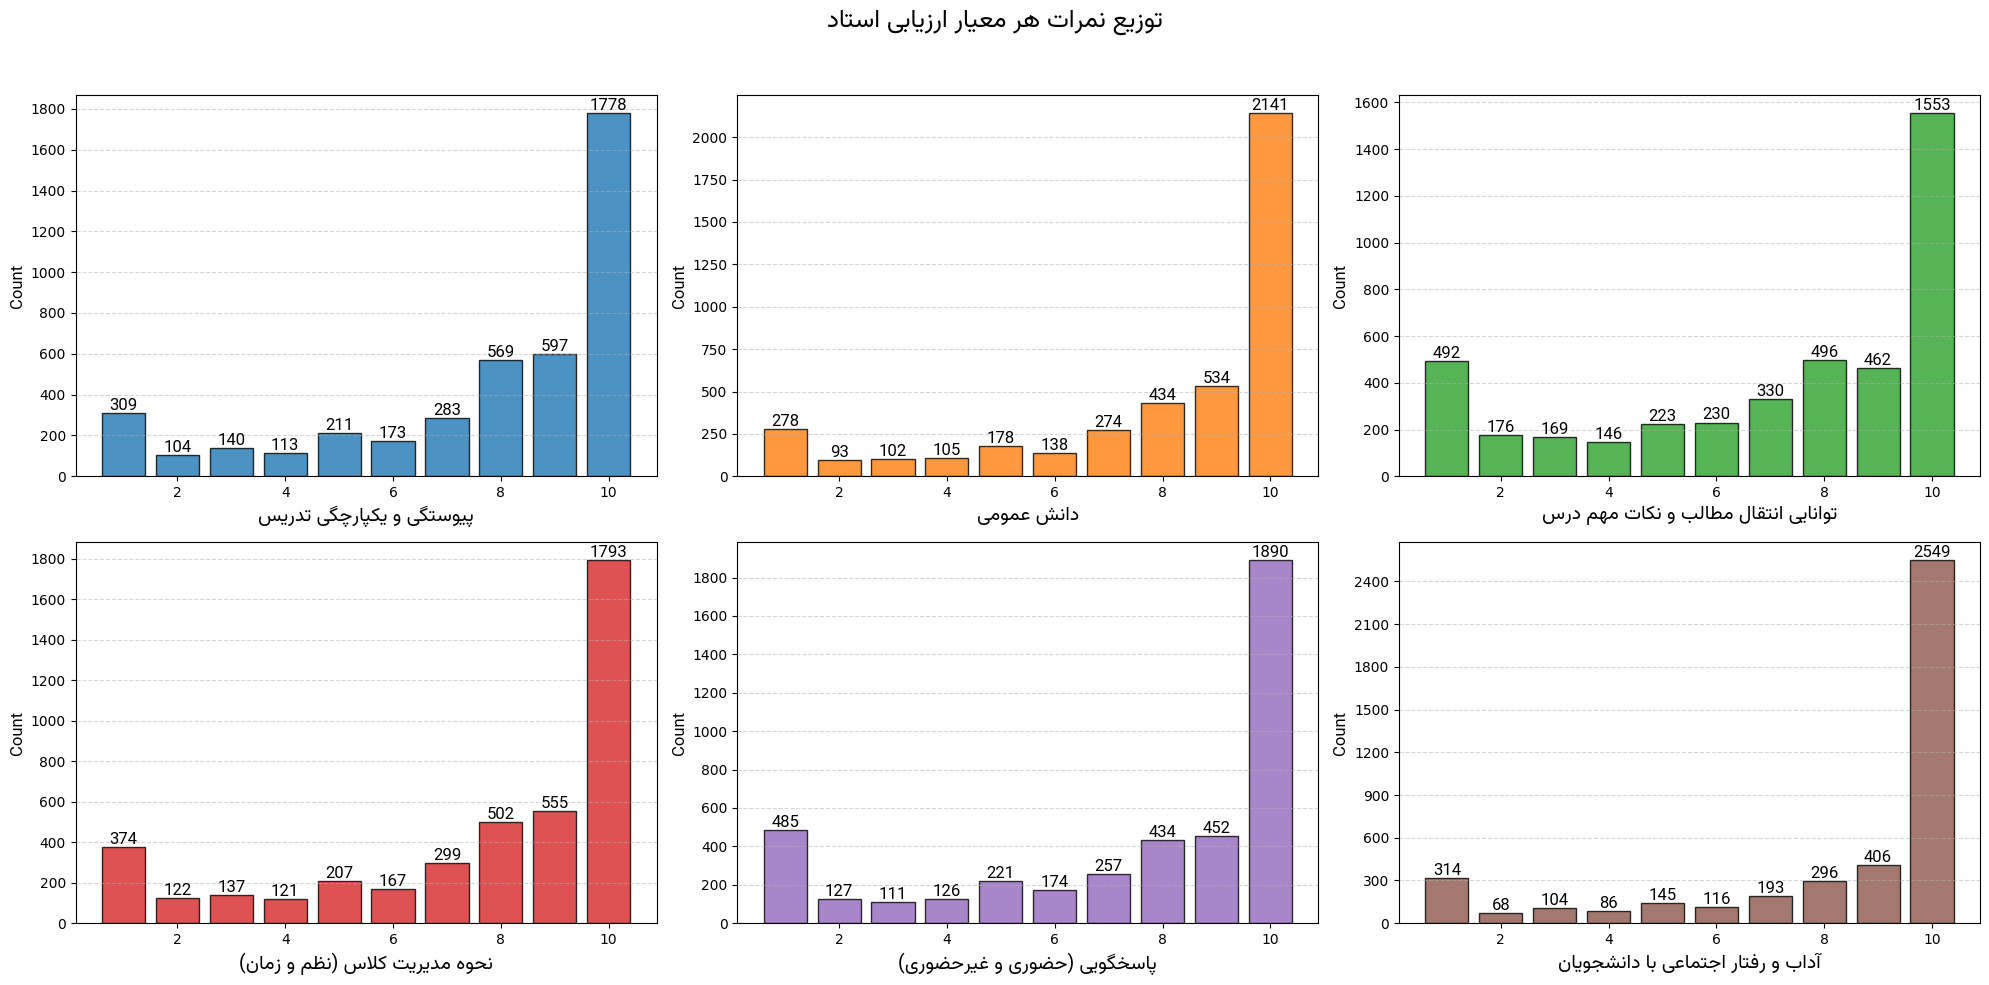

In [18]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator
import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib import font_manager as fm

# ---------------- Font Setup ----------------
vazir_font_path = "fonts/Vazirmatn-Regular.ttf"
vazir_font = fm.FontProperties(fname=vazir_font_path)

rating_labels = {
    'rating_1': 'پیوستگی و یکپارچگی تدریس',
    'rating_2': 'دانش عمومی',
    'rating_3': 'توانایی انتقال مطالب و نکات مهم درس',
    'rating_4': 'نحوه مدیریت کلاس (نظم و زمان)',
    'rating_5': 'پاسخگویی (حضوری و غیرحضوری)',
    'rating_6': 'آداب و رفتار اجتماعی با دانشجویان'
}

ratings = list(rating_labels.keys())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(ratings):
    ax = axes[i]
    counts = df_parsed[col].value_counts().sort_index()
    bars = ax.bar(counts.index, counts.values, color=colors[i], edgecolor='black', alpha=0.8)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(int(height)),
                ha='center', va='bottom', fontsize=12, fontweight='bold', fontproperties=vazir_font)
    
    label_fa = get_display(arabic_reshaper.reshape(rating_labels[col]))
    ax.set_xlabel(label_fa, fontsize=14, fontweight='bold', fontproperties=vazir_font)
    ax.set_ylabel("Count", fontsize=12, fontproperties=vazir_font)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y', linestyle='--', alpha=0.5)

fig.suptitle(get_display(arabic_reshaper.reshape("توزیع نمرات هر معیار ارزیابی استاد")),
             fontsize=18, fontweight='bold', fontproperties=vazir_font)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [19]:
import pandas as pd
import re
from fuzzywuzzy import fuzz, process

df = df_parsed.copy()

def normalize_name(name):
    if not isinstance(name, str):
        return ""
    name = name.strip()                    
    name = re.sub(r"\s+", " ", name)     
    name = name.replace("ي", "ی")          
    name = name.replace("ك", "ک")        
    name = name.lower()                   
    name = re.sub(r"[^\w\s]", "", name)   
    return name

df["professor_name_norm"] = df["professor_name_raw"].apply(normalize_name)


In [20]:
unique_names = df["professor_name_norm"].dropna().unique().tolist()

In [21]:
THRESHOLD = 85

professor_id_map = {}  # name_norm -> id_professor
professor_counter = 1

for name in unique_names:
    matched = None
    for existing in professor_id_map:
        if fuzz.token_set_ratio(name, existing) >= THRESHOLD:
            matched = existing
            break
    if matched:
        professor_id_map[name] = professor_id_map[matched]
    else:
        professor_id_map[name] = professor_counter
        professor_counter += 1


In [22]:
df["id_professor"] = df["professor_name_norm"].map(professor_id_map)

In [23]:
import re
from fuzzywuzzy import fuzz

def normalize_numbers(text):
    if not isinstance(text, str):
        return ""
    persian_nums = "۰۱۲۳۴۵۶۷۸۹"
    arabic_nums = "٠١٢٣٤٥٦٧٨٩"
    for i, n in enumerate(persian_nums):
        text = text.replace(n, str(i))
    for i, n in enumerate(arabic_nums):
        text = text.replace(n, str(i))
    return text
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r"\s+", " ", text)      
    text = text.replace("ي", "ی").replace("ك", "ک")  
    text = normalize_numbers(text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.lower()


def create_professor_id(df, name_col="professor_name_raw", threshold=85):
    df["professor_name_norm"] = df[name_col].apply(normalize_text)
    unique_names = df["professor_name_norm"].dropna().unique()
    
    professor_id_map = {}
    counter = 1
    for name in unique_names:
        matched = None
        for existing in professor_id_map:
            if fuzz.token_set_ratio(name, existing) >= threshold:
                matched = existing
                break
        if matched:
            professor_id_map[name] = professor_id_map[matched]
        else:
            professor_id_map[name] = counter
            counter += 1
    df["id_professor"] = df["professor_name_norm"].map(professor_id_map)
    return df

def normalize_course(df, course_col="course_name"):
    df["course_name_norm"] = df[course_col].apply(normalize_text)
    return df

def map_grading_status(text):
    text = normalize_text(text)
    if any(k in text for k in ["آسان", "راحت", "easy", "خوب"]):
        return "آسان"
    elif any(k in text for k in ["منصف", "fair"]):
        return "منصفانه"
    elif any(k in text for k in ["سخت", "سختگیر", "hard"]):
        return "سختگیر"
    else:
        return "نامشخص"

def map_attendance_status(text):
    text = normalize_text(text)
    if any(k in text for k in ["سخت", "سختگیر", "strict"]):
        return "سختگیر"
    elif any(k in text for k in ["متوسط", "medium"]):
        return "متوسط"
    elif any(k in text for k in ["آزاد", "free"]):
        return "آزاد"
    else:
        return "نامشخص"

def standardize_status(df):
    df["grading_status"] = df["grading_status_raw"].apply(map_grading_status)
    df["attendance_status"] = df["attendance_status_raw"].apply(map_attendance_status)
    return df

In [13]:
df = df_parsed.copy()  

df = create_professor_id(df, "professor_name_raw")

df = normalize_course(df, "course_name")

df = standardize_status(df)

df.head()

,channel_username,message_id,text,date,fetched_at,professor_name_raw,department,course_name,rating_1,rating_2,...,attendance_status_raw,exam_enough_raw,term,comment_text,error_parse,professor_name_norm,id_professor,course_name_norm,grading_status,attendance_status
0,ostad_elmosi,4728,🧑‍🏫 اصغر آب خضر\n🏫 #تربیت_بدنی\n📒 اصغر آب خضر\...,2025-12-11 16:41:18+00:00,2026-01-04 17:02:35.098765+00:00,اصغر آب خضر,اصغر آب خضر,اصغر آب خضر,1.0,1.0,...,یادم نمیاد,خیر,مهر 1401,چیزی اضافه ایی نیست\n~~~~~~~~~~~~~~~~~\nبرای ث...,0,اصغر آب خضر,1,اصغر آب خضر,نامشخص,نامشخص
1,ostad_elmosi,4727,🧑‍🏫 فاطمه مهدی زاده سراج\n🏫 #معماری_و_شهرسازی\...,2025-10-10 11:21:44+00:00,2026-01-04 17:02:35.103537+00:00,فاطمه مهدی زاده سراج,فاطمه مهدی زاده سراج,مبانی طراحی ۲,10.0,10.0,...,یادم نمیاد,بله,بهمن ۱۴۰۳,با دکتر طباطبایی و دو سه تا تی ای میان سر کلاس...,0,فاطمه مهدی زاده سراج,2,مبانی طراحی 2,منصفانه,نامشخص
2,ostad_elmosi,4726,🧑‍🏫 دکتر بخشایش\n🏫 #مهندسی_مواد\n📒 مواد پیشرفت...,2025-10-10 11:21:31+00:00,2026-01-04 17:02:35.105848+00:00,دکتر بخشایش,دکتر بخشایش,مواد پیشرفته,10.0,10.0,...,حضور مهم است و تاثیر مستقیم دارد,بله,بهمن 1401,استاد مطلعی هستند و اطلاعات به روزی دارند.\n~~...,0,دکتر بخشایش,3,مواد پیشرفته,منصفانه,نامشخص
3,ostad_elmosi,4725,🧑‍🏫 رضا انتظاری ملکی\n🏫 #مهندسی_کامپیوتر\n📒 مب...,2025-10-10 11:21:28+00:00,2026-01-04 17:02:35.107836+00:00,رضا انتظاری ملکی,رضا انتظاری ملکی,مباحث ویژه نرم افزار ۱,10.0,10.0,...,حضور مهم است و تاثیر مستقیم دارد,بله,بهمن ۱۴۰۳,استاد بسیار خوش اخلاق و محترمی هستند. تعداد تم...,0,رضا انتظاری ملکی,4,مباحث ویژه نرم افزار 1,منصفانه,نامشخص
4,ostad_elmosi,4724,🧑‍🏫 عین الله خنجری\n🏫 #مهندسی_کامپیوتر\n📒 پایگ...,2025-10-10 11:21:17+00:00,2026-01-04 17:02:35.109761+00:00,عین الله خنجری,عین الله خنجری,پایگاه داده پیشرفته,8.0,6.0,...,حضور و غیاب نمی کند,بله,بهمن ۱۴۰۳,تو نمره دادن پروژه‌ها بسیار رندوم و بی‌منطق عم...,0,عین الله خنجری,5,پایگاه داده پیشرفته,آسان,نامشخص


INFO:     127.0.0.1:59458 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:59458 - "GET /openapi.json HTTP/1.1" 200 OK


In [25]:
import re
from hazm import Normalizer, word_tokenize, stopwords_list

normalizer = Normalizer()
stopwords = set(stopwords_list())

def preprocess_fa(text):
    if not isinstance(text, str):
        return ""

    text = normalizer.normalize(text)

    text = re.sub(r"http\S+|www\S+|\d+", "", text)
    text = re.sub(r"[^\w\s]", " ", text)

    tokens = word_tokenize(text)

    tokens = [t for t in tokens if t not in stopwords and len(t) > 1]

    return " ".join(tokens)

df["comment_clean"] = df["comment_text"].apply(preprocess_fa)


ModuleNotFoundError: No module named 'hazm'

In [ ]:
positive_words = {
    "خوب", "عالی", "منصفانه", "محترم", "خوش", "عالیه",
    "به‌روز", "اوکی", "مناسب", "راضی"
}

negative_words = {
    "بد", "افتضاح", "بی‌منطق", "ضعیف", "رندوم",
    "ناراضی", "بدترین", "سخت", "مزخرف"
}

def rule_based_sentiment(text):
    if not text:
        return 0

    score = 0
    for w in text.split():
        if w in positive_words:
            score += 1
        elif w in negative_words:
            score -= 1

    # نرمال‌سازی به بازه [-1, 1]
    if score > 0:
        return 1
    elif score < 0:
        return -1
    else:
        return 0

df["score_sentiment"] = df["comment_clean"].apply(rule_based_sentiment)

label_map = {-1: "منفی", 0: "خنثی", 1: "مثبت"}
df["sentiment_label"] = df["score_sentiment"].map(label_map)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "HooshvareLab/bert-base-parsbert-sentiment-snappfood"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

label_map = {0: -1, 1: 0, 2: 1}  # negative, neutral, positive

def parsbert_sentiment(text):
    if not text:
        return 0

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128
    )

    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    return label_map[pred]

df["score_sentiment_bert"] = df["comment_clean"].apply(parsbert_sentiment)


In [ ]:
print(df[[
    "comment_text",
    "score_sentiment",
    "sentiment_label"
]].head())
